In [1]:
!pip install deap
!pip install seaborn
!apt install libgraphviz-dev
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 

In [2]:
import random
import numpy
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline
from deap import algorithms, base, creator, tools

In [3]:
#dictionaries storing task and robot locations for easier access and mapping:
#this way i dont need to implement classes for tasks and robots:
#do similar for robot capacities


#make list of task locations and use num tasks to make dict
#that adapts to nums
#add task scores, consumption, time taken as well


#Define Problem:


NUM_ROBOTS = 4

ROBOT_POS = [[1,0], [4,0], [7,0], [10, 0]]



task_dict = {
	0: [[1, 1], 5],
	1: [[1, 2], 5],
	2: [[0, 1], 5],
	3: [[3, 2], 5],
	4: [[3, 4], 5],
	5: [[3, 3], 5],
	6: [[7, 6], 5],
	7: [[8, 6], 5],
	8: [[7, 8], 5],
	9: [[8, 8], 5],
  10: [[0, 3], 5],
  11: [[0, 4], 5],
  12: [[1, 6], 5],
  13: [[2, 6], 5],
  14: [[4, 6], 5],
  15: [[5, 3], 5],
  16: [[7, 4], 5],
  17: [[5, 7], 5],
  18: [[8, 2], 5],
  19: [[10, 4], 5],
  20: [[11, 6], 5],

}

"""
  21: [[9, 5], 5],
  22: [[0, 9], 5],
  23: [[7, 3], 5],
  24: [[11, 1], 5],
  25: [[8, 12], 5],
  26: [[12, 10], 5],
  27: [[12, 2], 5],
  28: [[12, 6], 5],
  29: [[11, 4], 5],
  30: [[8, 11], 5]
"""
#add robot capacities as well - minimizing distance is the same as minimizing
robot_dict = {
  1: [1, 0],
  2: [4, 0],
  3: [7, 0],
  4: [10, 0]
}

coordinates_list = [info[0] for info in task_dict.values()]
print(coordinates_list)
TASK_POS = coordinates_list
NUM_TASKS = len(TASK_POS)

print(NUM_TASKS)
#print(task_dict)
#print(task_dict[1]) #get [x, y] for task 1: index [0] or [1] to get x or y respectively

[[1, 1], [1, 2], [0, 1], [3, 2], [3, 4], [3, 3], [7, 6], [8, 6], [7, 8], [8, 8], [0, 3], [0, 4], [1, 6], [2, 6], [4, 6], [5, 3], [7, 4], [5, 7], [8, 2], [10, 4], [11, 6]]
21


In [4]:
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

def create_chromosome (n, m): #n robots, m tasks
  chromosome = []

  #tasks = random.sample(range(1, m + 1), m) #create random permutation on m tasks
  tasks = random.sample(range(0, m), m) #create random permutation on m tasks
  robots = robots = [random.randint(1, n) for x in range(m)] #create random permutation of m assignments of n robots

  chromosome = tasks + robots
  return chromosome

#print(chromosome[:NUM_TASKS]) # tasks
#print(chromosome[NUM_TASKS:]) # robot assignments
#make dict of robots and tasks associated with their (x,y) coordinates

toolbox = base.Toolbox()
#toolbox.register("tasks", random.sample, range(NUM_TASKS), NUM_TASKS)
toolbox.register("chromosome", create_chromosome, NUM_ROBOTS, NUM_TASKS)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.chromosome)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
import math


#improved fitness function that takes going back home into account
import numpy as np
# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
# Modified fitness function for distance that takes into account the changing robot position after each task
# and the new structure of task_dict which now includes task duration
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    #distances_per_robot = {robot: 0 for robot in set(robots)}
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        # Change here: Extract just the task location from the new task_dict structure
        task_location = task_dict[task][0]  # Now task_dict[task] is a list, task_location is the first element
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        #distances_per_robot[robot] += distance_to_task  # Sum distance for each robot
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    # Calculate distance for each robot to return to its initial position
    for robot, initial_position in robot_dict.items():
        # Get the final position of the robot after completing all tasks
        final_position = robot_positions[robot]
        # Calculate the distance from the final position back to the initial position
        distance_to_initial_position = calculate_distance(final_position, initial_position)
        # Add this distance to the total distance and the distance for this robot
        total_distance += distance_to_initial_position
        #distances_per_robot[robot] += distance_to_initial_position

    average_distance = total_distance / len(tasks)
    return total_distance, average_distance#, distances_per_robot





# Function to calculate Euclidean distance between two points
def calculate_distance3(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Assume constant speed for simplicity
speed = 1.0  # units per time unit

def total_time_fitness_with_return(tasks, robots, task_dict, robot_dict):
    robot_positions = robot_dict.copy()  # Maintain original starting positions
    robot_end_times = {robot: 0 for robot in robot_dict}  # Track when each robot is free

    for task, robot in zip(tasks, robots):
        task_location, task_duration = task_dict[task]  # Unpacking directly from the list
        robot_location = robot_positions[robot]

        # Calculate travel time to the task
        travel_time = calculate_distance3(robot_location, task_location) / speed

        # Start time for this task
        start_time = max(robot_end_times[robot], robot_end_times[robot] + travel_time)

        # Update robot's end time after this task
        robot_end_times[robot] = start_time + task_duration

        # Update robot position
        robot_positions[robot] = task_location

    # Calculate travel time to return to initial position for each robot
    for robot, end_time in robot_end_times.items():
        initial_position = robot_dict[robot]  # Initial position of the robot
        return_travel_time = calculate_distance3(robot_positions[robot], initial_position) / speed
        robot_end_times[robot] += return_travel_time  # Add return travel time to end time

    # The fitness is the maximum of end times across all robots
    return max(robot_end_times.values())


def evalSchedule(individual):
  tasks = individual[:NUM_TASKS]
  robots = individual[NUM_TASKS:]
  #sum = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
  max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
  total_distance, average_distance= updated_distance_fitness(tasks, robots, task_dict, robot_dict)

  return (total_distance, max_time_taken,)


In [6]:
tasks = [0,2,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
robots = [1,1,1,2,2,2,3,3,3,3,1,2,3,1,2,3,4,4,4,3,2,2,3,4,4,3,2,2,1,1,2]
print(len(robots))
#tasks = [0,1,2,3,4]
#robots = [1,1,2,3,3]


#print(get_all_coordinates(tasks, task_dict))
#print(get_all_coordinates(robots, robot_dict)) #this needs to be updated for distances
ind = tasks + robots#[0,1,2,3,4,1,1,2,3,3]
#print(evalSchedule(ind))

31


In [7]:
toolbox.register("evaluate", evalSchedule)
#toolbox.register("select", tools.selTournament,tournsize=3) #10 did well - SO DID 20
 #3
toolbox.register("select", tools.selNSGA2)

from deap import tools

def custom_crossover_single_child(ind1, ind2):
    # Clone the input individuals to avoid modifying the originals
    copy1, copy2 = toolbox.clone(ind1), toolbox.clone(ind2)
    #print("copy1:")
    #print(copy1)
    #print("copy2:")
    #print(copy2)

    # Extract the tasks halves
    tasks_half1, tasks_half2 = copy1[:NUM_TASKS], copy2[:NUM_TASKS]

    # Apply PMX only to the tasks halves and take one of the resulting halves for the child
    #tasks_half_child, _ = tools.cxPartialyMatched(tasks_half1, tasks_half2) # cxUniformPartialyMatched
    tasks_half_child1, tasks_half_child2 = tools.cxUniformPartialyMatched(tasks_half1, tasks_half2, 0.1) #0.01#0.001
    # For the robot assignments half, choose one parent's half to combine with the tasks half of the child
    # This example chooses the robot assignments half from the first parent

    #child = tasks_half_child + copy1[NUM_TASKS:]
    new_individual1 = creator.Individual(tasks_half_child1 + copy1[NUM_TASKS:])
    new_individual2 = creator.Individual(tasks_half_child2 + copy2[NUM_TASKS:])

    # Clear the fitness value of the child since it's a new individual
    #del child.fitness.values

    #print(child)

    #return child, #MAIN
    return (new_individual1, new_individual2,)


# Register the custom crossover function in the toolbox
toolbox.register("mate", custom_crossover_single_child)

MUTATION_P = 0.05#0.01#0.23 # 0.001#0.001#.001 #0.1

toolbox.register("mutate_robots", tools.mutUniformInt, low=1, up=NUM_ROBOTS, indpb=MUTATION_P) #0.1
toolbox.register("mutate_tasks", tools.mutShuffleIndexes, indpb=MUTATION_P) #0.1 -> what ahppens if i set this to zero - can be used for ablation studies

def mutate(individual): #THIS NEEDS TO DIRECTLY CHANGE THE IND AND NOT THE COPY - implemented (further checking needed)
    # Make a copy of the individual to avoid direct modifications
    #ind_copy = toolbox.clone(individual) #to revert just change individual with ind_copy

    # Perform mutation on the tasks half
    tasks_half = individual[:NUM_TASKS]
    mutated_tasks_half, = toolbox.mutate_tasks(tasks_half)
    individual[:NUM_TASKS] = mutated_tasks_half

    # Perform mutation on the robot assignments half
    robot_assignments_half = individual[NUM_TASKS:]
    mutated_robot_assignments_half, = toolbox.mutate_robots(robot_assignments_half)
    individual[NUM_TASKS:] = mutated_robot_assignments_half

    # Clear the fitness values of the mutated individual
    #del ind_copy.fitness.values
    #print individual

    return individual,

# Ensure the 'mutate' function is registered correctly in the toolbox
toolbox.register("mutate", mutate)

In [8]:
def varOrModified(population, toolbox, lambda_, cxpb, mutpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = [toolbox.clone(i) for i in random.sample(population, 2)]
            kids = toolbox.mate(ind1, ind2)
            kid = kids[0]  # Unpacking the first child
            del kid.fitness.values
            offspring.append(kid)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(random.choice(population))

    return offspring


In [9]:
NGEN = 1000
popSize = MU = 500
LAMBDA = 1000
CXPB = 0.5#0.7 #0.5
MUTPB = 0.5#0.3#0.5#x=0.3

In [10]:
import numpy

# Function to avoid similar solutions
def pareto_eq(ind1, ind2, atol=1e-4, rtol=1e-3):
    # Extract the task and robot parts of the individuals
    tasks1, robots1 = ind1[:NUM_TASKS], ind1[NUM_TASKS:]
    tasks2, robots2 = ind2[:NUM_TASKS], ind2[NUM_TASKS:]

    # Calculate the fitness for each individual
    total_distance1, max_time_taken1 = calculate_fitness(tasks1, robots1)
    total_distance2, max_time_taken2 = calculate_fitness(tasks2, robots2)

    # Use a comparison method, e.g., numpy.allclose, to compare the fitness values
    return numpy.allclose([total_distance1, max_time_taken1], [total_distance2, max_time_taken2], atol=atol, rtol=rtol)

def calculate_fitness(tasks, robots):
    max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
    total_distance, _ = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
    return total_distance, max_time_taken

# Use the modified pareto_eq function as the similarity checker and store solutions in a hall of fame (hof)
hof = tools.ParetoFront(similar=lambda x, y: pareto_eq(x, y, atol=1e-10, rtol=1e-7))


In [11]:
pop = toolbox.population(n=popSize)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean, axis=0)
stats.register("std", numpy.std, axis=0)
stats.register("min", numpy.min, axis=0)
stats.register("max", numpy.max, axis=0)
logbook = tools.Logbook() #

In [12]:
fitnesses = [toolbox.evaluate(ind) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for g in range(NGEN):
    print("-- Generation %i --" % g)

    # Generate offspring using VarOr
    offspring = varOrModified(pop, toolbox, LAMBDA, CXPB, MUTPB)
    # Note that the MUTPB is a bit different here. It is the proportion of individuals that will be mutated, rather than crossed over.
    # So with varOr MUTPB + CXPB <= 1.0

    # Evaluate offspring
    invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind) for ind in invalid_inds]
    for ind, fit in zip(invalid_inds, fitnesses):
        ind.fitness.values = fit

    nextGenOffspring = toolbox.select(pop + offspring, MU)
    nextGenOffspring = list(map(toolbox.clone, nextGenOffspring))
    pop[:] = nextGenOffspring

    hof.update(pop) #This version keeps the HoF a constant size. See also hof.insert()

    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.select("gen")
avgs = logbook.select("avg")
stds = logbook.select("std")

avgs_distance = [item[0] for item in avgs]
avgs_time = [item[1] for item in avgs]

avgs

[array([129.87536323,  77.60341925]),
 array([124.15875489,  72.82782988]),
 array([118.91519191,  70.50038827]),
 array([115.07809247,  68.66528383]),
 array([111.11253927,  67.94225902]),
 array([108.20109541,  66.17543483]),
 array([106.14643267,  64.45533553]),
 array([103.96865915,  63.4825754 ]),
 array([102.11517059,  62.67691002]),
 array([100.63849853,  61.96918245]),
 array([98.4804941 , 61.84042474]),
 array([97.64253308, 60.19977344]),
 array([95.85045129, 59.26705825]),
 array([94.24249389, 58.64808728]),
 array([92.25305221, 58.96802343]),
 array([90.66753086, 59.14689859]),
 array([88.87058308, 58.80438336]),
 array([87.75242779, 57.87495956]),
 array([86.33789249, 58.30431246]),
 array([84.55264844, 58.72367319]),
 array([83.64838191, 58.43107901]),
 array([82.54051636, 58.07840585]),
 array([81.72192099, 57.66749191]),
 array([80.83162443, 57.25254233]),
 array([79.23042739, 58.35418687]),
 array([79.50618875, 57.1019811 ]),
 array([79.9762427 , 55.14306845]),
 array([

Text(0, 0.5, 'Fitness (energy / distance)')

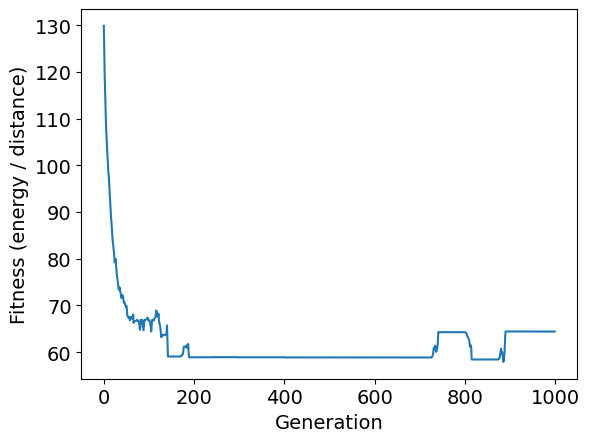

In [14]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs_distance)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness (energy / distance)")

Text(0, 0.5, 'Fitness (time)')

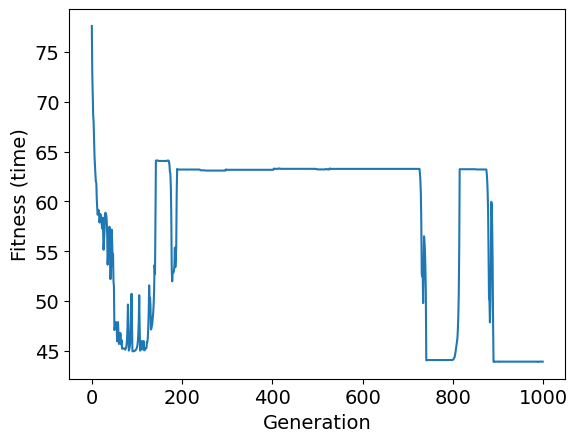

In [15]:
fig2, ax2 = plt.subplots()
line2 = ax2.plot(gen, avgs_time)
ax2.set_xlabel("Generation")
ax2.set_ylabel("Fitness (time)")

[56.505214902076155, 57.26914692457637, 58.520234929700344, 60.2284388621997, 60.25749891512222, 62.658520349277715, 63.35223261856256, 63.424851875125256, 63.74330849220107, 64.28131581093703, 64.35393506749972, 64.56244040186183]
[63.75683111004041, 58.10654957016753, 55.35848547237225, 52.268827230335916, 45.47603286813174, 44.594553449872045, 44.48159109798991, 44.44124800267047, 44.07768723046357, 43.964724878581436, 43.924381783262, 43.67004637770997]


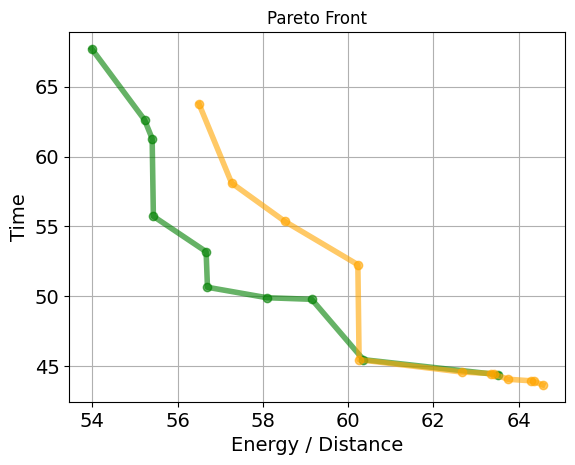

In [16]:
#CANT VISUALLIZE SOLUTIONS IN THE PARETO FRONT - JUST THE FUNCTION AND RELATIONS - UNLESS I CAN THINK OF A WAY TO DO IT
import seaborn as sns
fitnesses = [x.fitness.values for x in hof]
x = [f[0] for f in fitnesses]
y = [f[1] for f in fitnesses]
#ParetoDistances = [61.84680920788658, 61.92502464119043, 62.397160596190005, 63.22270528756536, 65.45978774482647, 65.81896134794393, 61.79514857058645, 62.498302940739315, 62.970438895738894, 64.22999561087424, 66.32852001800912, 66.47273545084691, 66.99927406179289]
#ParetoTimes = [49.95372705298949, 49.43686083358102, 49.43686083358101, 46.064495102245985, 44.07768723046357, 43.964724878581436, 58.485130347850344, 57.97718216707524, 52.97718216707524, 47.47603286813174, 47.07983482411062, 46.46011823444822, 46.39157519268184]
#x = ParetoDistances
#y = ParetoTimes
#best nsga so far
xy = [55.08354532170815, 55.90948306550162, 58.57718413634599, 60.60624418926851, 61.635106528972486, 64.10793061471726]
xyz = [76.74753589495499, 64.37825031020934, 58.03275925283612, 52.47603286813173, 46.10654957016754, 44.402242550800324]

nb_nsga_distances = [57.85562149294847, 58.32775744794805, 59.22510479091267, 59.65263577040343, 60.12748881567084, 61.09660086334174, 61.14822683948875, 63.55586769224235]
nb_nsga_times = [61.54320376686505, 55.35848547237225, 54.65417845300504, 49.59455344987204, 48.41811047550525, 47.654178453005045, 45.46941344953365, 43.67004637770997]

nb_nsga_distances = [57.85562149294847, 58.32775744794805, 59.22510479091267, 59.65263577040343, 60.12748881567084, 61.09660086334174, 61.14822683948875, 63.55586769224235]
nb_nsga_times = [61.54320376686505, 55.35848547237225, 54.65417845300504, 49.59455344987204, 48.41811047550525, 47.654178453005045, 45.46941344953365, 43.67004637770997]

#New nsga
new_x = [61.79514857058645, 62.498302940739315, 62.970438895738894, 64.22999561087424, 66.32852001800912, 66.47273545084691, 66.99927406179289]
new_y = [58.485130347850344, 57.97718216707524, 52.97718216707524, 47.47603286813174, 47.07983482411062, 46.46011823444822, 46.39157519268184]

#Old nsga
old_x = [61.84680920788658, 61.92502464119043, 62.397160596190005, 63.22270528756536, 65.45978774482647, 65.81896134794393]
old_y = [49.95372705298949, 49.43686083358102, 49.43686083358101, 46.064495102245985, 44.07768723046357, 43.964724878581436]

old_a = [53.59861029090911, 54.56974795120513, 55.401912061178585, 55.560292808214804, 61.74351512908458, 61.84787039662648, 62.30584103742765, 63.72934981488617, 64.56151392485961, 64.83200247192156, 65.34094957616563, 65.62767034383161]
old_b = [82.58525823478661, 61.61500641845432, 61.25583281533687, 61.14218233270955, 58.41640786499873, 53.777284078622706, 46.89024643050483, 46.20079285608123, 45.84161925296378, 44.402242550800324, 43.924381783262, 43.670046377709966]

#FINAL PARETO FRONT
bestx =[53.9913976987191, 55.227465676218884, 55.40561126109219, 55.43467131401471, 56.670739291514494, 56.70247514092435, 58.09692386546036, 59.14623917374661, 60.359178386176765, 63.521456046345136]
besty =[67.69890871741394, 62.62511840008252, 61.28469515504084, 55.72796877033645, 53.20010472533603, 50.65417845300504, 49.90611435520976, 49.793152003327634, 45.47603286813173, 44.402242550800324]

#sns.kdeplot(x,y)
# Plot the Pareto front

##plt.plot(old_x, old_y, marker='o')
#plt.plot(new_x, new_y, marker='o')
#plt.plot(nb_nsga_distances, nb_nsga_times, marker='o')
#plt.plot(bestx, besty, marker='x')

print(x)
print(y)
plt.plot(bestx, besty, marker='o', color='green', linewidth=4, alpha=0.6) #BEST OBTAINED FRONT
plt.plot(x, y, marker='o', color='orange', linewidth=4, alpha=0.6)
plt.title('Pareto Front')
plt.xlabel('Energy / Distance')
plt.ylabel('Time')
plt.grid(True)
plt.show()

# distance = [61.84680920788658, 61.92502464119043, 62.397160596190005, 63.22270528756536, 65.45978774482647, 65.81896134794393]
# time = [49.95372705298949, 49.43686083358102, 49.43686083358101, 46.064495102245985, 44.07768723046357, 43.964724878581436]
#

In [18]:
# Fitness values from the Pareto front
pareto_fitnesses = [(f[0], f[1]) for f in fitnesses]

# Function to find individuals with matching fitness values
def find_individuals_by_fitness(hof, target_fitness):
    matched_individuals = [ind for ind in hof if ind.fitness.values == target_fitness]
    return matched_individuals

for i in range(0, len(fitnesses)):
  # Choose a specific point to investigate (for example, the first one)
  point_of_interest = pareto_fitnesses[i]
  print(point_of_interest)

  # Find individuals in the Hall of Fame with matching fitness
  matched_individuals = find_individuals_by_fitness(hof, point_of_interest)

  # Now you have the individuals that correspond to your point of interest
  for ind in matched_individuals:
      print("Individual:", ind)
      print("Tasks:", ind[:NUM_TASKS])
      print("Robot Assignments:", ind[NUM_TASKS:])


#(63.22270528756536, 46.064495102245985)
#BEST Individual: [2, 16, 0, 7, 20, 15, 17, 1, 8, 10, 3, 19, 11, 5, 9, 6, 18, 4, 12, 13, 14, 1, 4, 1, 4, 4, 3, 3, 1, 3, 1, 2, 4, 1, 2, 3, 3, 4, 2, 2, 2, 2]
#Tasks: [2, 16, 0, 7, 20, 15, 17, 1, 8, 10, 3, 19, 11, 5, 9, 6, 18, 4, 12, 13, 14]
#Robot Assignments: [1, 4, 1, 4, 4, 3, 3, 1, 3, 1, 2, 4, 1, 2, 3, 3, 4, 2, 2, 2, 2]

#PRINT PARETO OPTIMAL SOLUTIONS FROM CURRENT RUN:

(56.505214902076155, 63.75683111004041)
Individual: [14, 20, 17, 19, 15, 8, 9, 4, 0, 7, 6, 18, 13, 2, 12, 11, 10, 1, 5, 3, 16, 3, 4, 3, 4, 2, 3, 3, 2, 1, 3, 3, 4, 2, 1, 2, 2, 2, 2, 2, 2, 3]
Tasks: [14, 20, 17, 19, 15, 8, 9, 4, 0, 7, 6, 18, 13, 2, 12, 11, 10, 1, 5, 3, 16]
Robot Assignments: [3, 4, 3, 4, 2, 3, 3, 2, 1, 3, 3, 4, 2, 1, 2, 2, 2, 2, 2, 2, 3]
(57.26914692457637, 58.10654957016753)
Individual: [14, 20, 17, 19, 15, 8, 9, 4, 0, 7, 6, 18, 13, 1, 12, 11, 10, 2, 5, 3, 16, 3, 4, 3, 4, 2, 3, 3, 2, 1, 3, 3, 4, 2, 1, 2, 2, 2, 1, 2, 2, 3]
Tasks: [14, 20, 17, 19, 15, 8, 9, 4, 0, 7, 6, 18, 13, 1, 12, 11, 10, 2, 5, 3, 16]
Robot Assignments: [3, 4, 3, 4, 2, 3, 3, 2, 1, 3, 3, 4, 2, 1, 2, 2, 2, 1, 2, 2, 3]
(58.520234929700344, 55.35848547237225)
Individual: [14, 19, 17, 20, 15, 8, 9, 4, 0, 7, 6, 18, 13, 1, 12, 11, 10, 2, 5, 3, 16, 3, 4, 3, 4, 2, 3, 3, 2, 1, 3, 3, 4, 2, 1, 2, 2, 1, 1, 2, 2, 3]
Tasks: [14, 19, 17, 20, 15, 8, 9, 4, 0, 7, 6, 18, 13, 1, 12, 11, 10, 2, 5, 3, 16]
Robot Assignments: 

In [ ]:
# PARETO OPTIMAL SOLUTIONS FROM BEST RUN (GREEN)
# RUN IN MAIN VIISUALISER

"""

(53.9913976987191, 67.69890871741394)
Individual: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0, 4, 4, 2, 4, 3, 2, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 2, 2]
Tasks: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0]
Robot Assignments: [4, 4, 2, 4, 3, 2, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 2, 2]

(55.227465676218884, 62.62511840008252)
Individual: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0, 4, 4, 2, 4, 3, 2, 3, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 2, 2]
Tasks: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0]
Robot Assignments: [4, 4, 2, 4, 3, 2, 3, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 2, 2]

(55.40561126109219, 61.28469515504084)
Individual: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 2, 1, 0, 4, 4, 2, 4, 3, 2, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 1, 2, 2]
Tasks: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 2, 1, 0]
Robot Assignments: [4, 4, 2, 4, 3, 2, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 1, 2, 2]

(55.43467131401471, 55.72796877033645)
Individual: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0, 4, 4, 2, 4, 3, 2, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 1, 1]
Tasks: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0]
Robot Assignments: [4, 4, 2, 4, 3, 2, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 1, 1]

(56.670739291514494, 53.20010472533603)
Individual: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0, 4, 4, 2, 4, 3, 2, 3, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 1, 1]
Tasks: [19, 20, 3, 9, 15, 5, 4, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 1, 2, 0]
Robot Assignments: [4, 4, 2, 4, 3, 2, 3, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 2, 1, 1]


(55.963508544995946, 50.313755207963354)
Individual: [19, 20, 3, 9, 15, 4, 5, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 2, 1, 0, 4, 4, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 1, 2, 1]
Tasks: [19, 20, 3, 9, 15, 4, 5, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 2, 1, 0]
Robot Assignments: [4, 4, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 1, 2, 1]

(58.09692386546036, 49.90611435520976)
Individual: [19, 20, 3, 9, 15, 4, 5, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 2, 1, 0, 4, 4, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 1, 1, 1]
Tasks: [19, 20, 3, 9, 15, 4, 5, 13, 8, 14, 17, 12, 6, 7, 11, 16, 10, 18, 2, 1, 0]
Robot Assignments: [4, 4, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 1, 1, 1]

(59.14623917374661, 49.793152003327634)
Individual: [19, 20, 3, 9, 15, 4, 5, 13, 8, 14, 17, 12, 7, 6, 11, 16, 10, 18, 2, 1, 0, 4, 4, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 1, 1, 1]
Tasks: [19, 20, 3, 9, 15, 4, 5, 13, 8, 14, 17, 12, 7, 6, 11, 16, 10, 18, 2, 1, 0]
Robot Assignments: [4, 4, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 1, 1, 1]

(60.359178386176765, 45.47603286813173)
Individual: [19, 3, 5, 20, 14, 12, 17, 13, 6, 9, 16, 2, 18, 8, 4, 10, 15, 7, 11, 1, 0, 4, 2, 2, 4, 3, 2, 3, 2, 3, 4, 3, 1, 3, 4, 2, 1, 2, 4, 1, 1, 1]
Tasks: [19, 3, 5, 20, 14, 12, 17, 13, 6, 9, 16, 2, 18, 8, 4, 10, 15, 7, 11, 1, 0]
Robot Assignments: [4, 2, 2, 4, 3, 2, 3, 2, 3, 4, 3, 1, 3, 4, 2, 1, 2, 4, 1, 1, 1]

(63.521456046345136, 44.402242550800324)
Individual: [19, 2, 5, 20, 14, 12, 17, 13, 6, 9, 16, 10, 18, 8, 4, 11, 15, 7, 1, 3, 0, 4, 1, 2, 4, 3, 2, 3, 2, 3, 4, 3, 1, 3, 4, 2, 1, 2, 4, 1, 1, 1]
Tasks: [19, 2, 5, 20, 14, 12, 17, 13, 6, 9, 16, 10, 18, 8, 4, 11, 15, 7, 1, 3, 0]
Robot Assignments: [4, 1, 2, 4, 3, 2, 3, 2, 3, 4, 3, 1, 3, 4, 2, 1, 2, 4, 1, 1, 1]

"""